### Copyright (C) 2020 Sobhan Moradiyan Daghigh - All Rights Reserved
##### 12/5/2020

In [63]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize, LabelEncoder
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
%matplotlib inline

In [174]:
data = pd.read_excel("./DatasetForClustering.xlsx")
data.head(10)

,ID,ScopH,ScopIntpp,GoSchopp,GoSchcite,GoSchH,Field 1,Field 2,Field 3,Field 4,Field 5,Field 6,Field 7,Field 8,Field 9,Field 10
0,297,15.0,17.0,NaN,NaN,NaN,Zinc,Cadmium,Soil pollution,Organoclay,Calcareous Soil,Bioavailability,Sulfur-oxidizing bacteria,Manures,Soil solutions,Salinity
1,242,12.0,10.0,NaN,NaN,NaN,Yield,Medicinal Plant,Essential oils,Replacement corm,Germination,Azotobacter chroococcum,Crocus sativus,Phytotoxicity,Pseudomonas putida,Calcareous Soil
2,693,NaN,34.0,NaN,NaN,NaN,Wireless sensor networks,Quality of service,Sensor nodes,Sensor networks,Network lifetime,Congestion control,Smart Grid,Internet protocols,Routing protocols,Clustering
3,129,19.0,31.0,259.0,2593.0,25.0,Wireless sensor networks,Quality of service,Congestion control,Sensor nodes,Network lifetime,Sensor networks,Smart Grid,Routing protocols,Internet protocols,Clustering
4,556,7.0,8.0,42.0,283.0,10.0,Wireless sensor networks,Routing protocols,Quality of service,Sensor nodes,Smart Grid,Directional sensor network,Fairness,Coverage,Wireless multimedia sensor network,Optimization problems
5,571,NaN,NaN,38.0,59.0,4.0,Wheat\n\nSENSITIVITY-ANALYSIS,Energy productivity,Province,Fertilizers,Renewable energies,Crop,Systems,NaN,NaN,NaN
6,768,14.0,13.0,107.0,781.0,17.0,Wheat Production,Sensitivity analysis,BDLRF algorithm,Ann,Soft computing models,Automotive industry,Energy modeling,Energy lost,Exhaust Emission,Artificial neural network
7,447,8.0,3.0,212.0,488.0,12.0,Weighted Distributions,Hazard Rate,Lorenz curve,Preservation,Tsallis entropies,Maximum Entropy,Stochastic orders,Mean residual life,Shannon entropy,Gini Index
8,594,11.0,9.0,78.0,1005.0,15.0,Wedgelets,Microsoft Kinect sensor,Normal Vector,Non-linear least squares,Indoor environment,Robotics,Mser,Platelets,Markov Random Fields,Image segmentation
9,424,5.0,4.0,33.0,157.0,6.0,Wedgelets,Classifier fusion,Combining classifiers,Non-linear least squares,Multiple classifier systems,Decision template,Joint audio visual coding,Video subjective testing,Microphones,Bubble Histogram


In [175]:
data_segmented = pd.DataFrame(data.iloc[20:25, 6:9])
data_segmented

,Field 1,Field 2,Field 3
20,Unconstrained optimization,Global convergence,Conjugate gradient method
21,Ultrasound,Ultrasonics,Nanoparticles
22,Ultrasonography,Dog,Heart
23,Ultrasonic vibration,Electro-chemical discharge machining,Machining
24,Two-phase flow,Nucleation,Steam turbines


In [176]:
data_segmented.iloc[3, 1] = "Echography"
data_segmented

,Field 1,Field 2,Field 3
20,Unconstrained optimization,Global convergence,Conjugate gradient method
21,Ultrasound,Ultrasonics,Nanoparticles
22,Ultrasonography,Dog,Heart
23,Ultrasonic vibration,Echography,Machining
24,Two-phase flow,Nucleation,Steam turbines


In [177]:
def lable_encoder():
    code = 0
    lemmas = ""
    
    for index, rows in data_segmented.iterrows():
        for word in range(len(rows)):
            
            if not isinstance(rows[word], int):
                synset = wordnet.synsets(rows[word])
                if synset:
                    for syn in synset:
                        lemmas += str(syn.lemmas())
                    data_segmented.iloc[index - 20, word] = code

                    for index2, rows2 in data_segmented.iterrows():
                        for word2 in range(len(rows2)):
                            if not isinstance(rows2[word2], int):
                                if rows2[word2].lower() in lemmas:
                                    data_segmented.iloc[index2 - 20, word2] = code
                    code += 1
                else:
                    data_segmented.iloc[index - 20, word] = code
                    code += 1
                    
    return data_segmented

In [179]:
data_segmented = lable_encoder()
data_segmented

,Field 1,Field 2,Field 3
20,0,1,2
21,3,4,5
22,3,6,7
23,8,3,9
24,10,11,12


In [180]:
nb_classes = 13

def indices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

data_segmented = indices_to_one_hot(np.array(data_segmented, int), nb_classes)

In [181]:
data_segmented

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [273]:
# encoder = LabelEncoder()
# data_segmented.iloc[:, 0] = encoder.fit_transform(data_segmented.iloc[:, 0])
# data_segmented.iloc[:, 1] = encoder.fit_transform(data_segmented.iloc[:, 1])
# data_segmented.iloc[:, 2] = encoder.fit_transform(data_segmented.iloc[:, 2])

# data_segmented

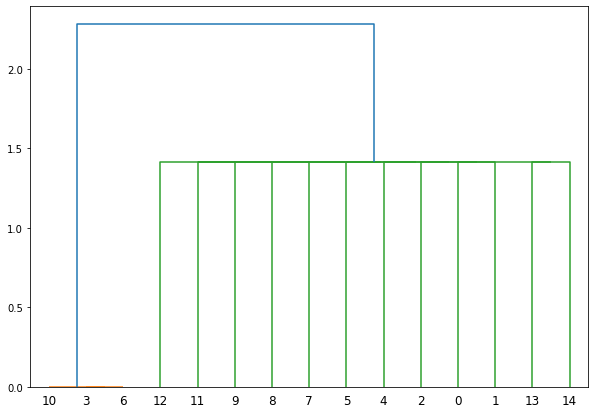

In [318]:
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(data_segmented, method='ward'))

In [28]:
df = pd.DataFrame([[1, 5, 9],
                   [2, 6, 9],
                   [3, 7, 9]], columns=['1st', '2nd', '3rd'])

df.head()

,1st,2nd,3rd
0,1,5,9
1,2,6,9
2,3,7,9


In [29]:
# df_scaled = normalize(df)
# df_scaled

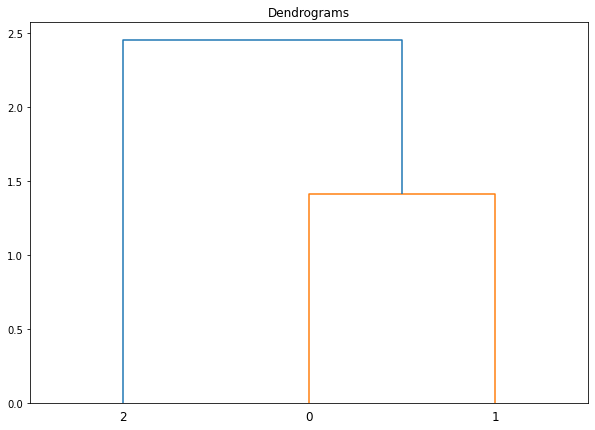

In [30]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df, method='ward'))

In [31]:
# data_encoded = LabelEncoder

In [32]:
# data_scaled = normalize(data)
# data_scaled

In [35]:
data_segmented

,Field 1,Field 2,Field 3
0,3,0,5
1,2,2,1
2,1,3,4
3,1,3,0
4,1,4,3
5,0,1,2


In [41]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
data_segmented = onehotencoder.fit_transform(np.array(data_segmented).sha)
# data = np.array(onehotencoder.fit_transform(data_segmented), dtype = np.str) 
data_segmented

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [201]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize, LabelEncoder
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from sklearn.cluster import AgglomerativeClustering

In [128]:
dataset = pd.read_excel("./DatasetForClustering.xlsx")
dataset.head()

,ID,ScopH,ScopIntpp,GoSchopp,GoSchcite,GoSchH,Field 1,Field 2,Field 3,Field 4,Field 5,Field 6,Field 7,Field 8,Field 9,Field 10
0,297,15.0,17.0,NaN,NaN,NaN,Zinc,Cadmium,Soil pollution,Organoclay,Calcareous Soil,Bioavailability,Sulfur-oxidizing bacteria,Manures,Soil solutions,Salinity
1,242,12.0,10.0,NaN,NaN,NaN,Yield,Medicinal Plant,Essential oils,Replacement corm,Germination,Azotobacter chroococcum,Crocus sativus,Phytotoxicity,Pseudomonas putida,Calcareous Soil
2,693,NaN,34.0,NaN,NaN,NaN,Wireless sensor networks,Quality of service,Sensor nodes,Sensor networks,Network lifetime,Congestion control,Smart Grid,Internet protocols,Routing protocols,Clustering
3,129,19.0,31.0,259.0,2593.0,25.0,Wireless sensor networks,Quality of service,Congestion control,Sensor nodes,Network lifetime,Sensor networks,Smart Grid,Routing protocols,Internet protocols,Clustering
4,556,7.0,8.0,42.0,283.0,10.0,Wireless sensor networks,Routing protocols,Quality of service,Sensor nodes,Smart Grid,Directional sensor network,Fairness,Coverage,Wireless multimedia sensor network,Optimization problems


In [129]:
dataset = dataset.drop(['ScopH', 'ScopIntpp', 'GoSchopp', 'GoSchcite', 'GoSchH'], axis=1)
dataset.head()

,ID,Field 1,Field 2,Field 3,Field 4,Field 5,Field 6,Field 7,Field 8,Field 9,Field 10
0,297,Zinc,Cadmium,Soil pollution,Organoclay,Calcareous Soil,Bioavailability,Sulfur-oxidizing bacteria,Manures,Soil solutions,Salinity
1,242,Yield,Medicinal Plant,Essential oils,Replacement corm,Germination,Azotobacter chroococcum,Crocus sativus,Phytotoxicity,Pseudomonas putida,Calcareous Soil
2,693,Wireless sensor networks,Quality of service,Sensor nodes,Sensor networks,Network lifetime,Congestion control,Smart Grid,Internet protocols,Routing protocols,Clustering
3,129,Wireless sensor networks,Quality of service,Congestion control,Sensor nodes,Network lifetime,Sensor networks,Smart Grid,Routing protocols,Internet protocols,Clustering
4,556,Wireless sensor networks,Routing protocols,Quality of service,Sensor nodes,Smart Grid,Directional sensor network,Fairness,Coverage,Wireless multimedia sensor network,Optimization problems


In [130]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        638 non-null    int64 
 1   Field 1   638 non-null    object
 2   Field 2   638 non-null    object
 3   Field 3   638 non-null    object
 4   Field 4   636 non-null    object
 5   Field 5   630 non-null    object
 6   Field 6   627 non-null    object
 7   Field 7   626 non-null    object
 8   Field 8   621 non-null    object
 9   Field 9   620 non-null    object
 10  Field 10  614 non-null    object
dtypes: int64(1), object(10)
memory usage: 55.0+ KB


In [131]:
dataset = dataset.fillna(' ')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638 entries, 0 to 637
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        638 non-null    int64 
 1   Field 1   638 non-null    object
 2   Field 2   638 non-null    object
 3   Field 3   638 non-null    object
 4   Field 4   638 non-null    object
 5   Field 5   638 non-null    object
 6   Field 6   638 non-null    object
 7   Field 7   638 non-null    object
 8   Field 8   638 non-null    object
 9   Field 9   638 non-null    object
 10  Field 10  638 non-null    object
dtypes: int64(1), object(10)
memory usage: 55.0+ KB


In [132]:
def connect_features():
    df = pd.DataFrame()
    df['ID'] = dataset['ID']
    df['Fields'] = dataset[['Field 1', 'Field 2', 'Field 3', 'Field 4', 'Field 5', 'Field 6', 'Field 7', 'Field 8', 'Field 9', 'Field 10']].agg('-'.join, axis=1)
    return df

In [134]:
dataset = connect_features()
dataset.head()

,ID,Fields
0,297,Zinc-Cadmium-Soil pollution-Organoclay-Calcare...
1,242,Yield-Medicinal Plant-Essential oils-Replaceme...
2,693,Wireless sensor networks-Quality of service-Se...
3,129,Wireless sensor networks-Quality of service-Co...
4,556,Wireless sensor networks-Routing protocols-Qua...


In [168]:
for i in dataset.iloc[:5,].iterrows():
    print(i)

(0, ID                                                      297
Fields    Zinc-Cadmium-Soil pollution-Organoclay-Calcare...
Name: 0, dtype: object)
(1, ID                                                      242
Fields    Yield-Medicinal Plant-Essential oils-Replaceme...
Name: 1, dtype: object)
(2, ID                                                      693
Fields    Wireless sensor networks-Quality of service-Se...
Name: 2, dtype: object)
(3, ID                                                      129
Fields    Wireless sensor networks-Quality of service-Co...
Name: 3, dtype: object)
(4, ID                                                      556
Fields    Wireless sensor networks-Routing protocols-Qua...
Name: 4, dtype: object)


In [222]:
# similarity_matrix = np.zeros((dataset.shape[0], dataset.shape[0]))
# for person1 in dataset.iloc[333:,].iterrows():
#     for person2 in dataset.iterrows():
#         similarity_matrix[person1[0], person2[0]] = spacy_semantic_similarity(person1[1]['Fields'], person2[1]['Fields'])
        
# similarity_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.68453741, 0.71408574, 0.66912191, ..., 1.        , 0.83309422,
        0.83355889],
       [0.84662399, 0.86481099, 0.71993989, ..., 0.83309422, 1.        ,
        0.83549071],
       [0.64814572, 0.68310445, 0.76247785, ..., 0.83355889, 0.83549071,
        1.        ]])

[6 6 0 0 5 2 1 0 1 0 4 1 0 5 4 2 1 2 1 5 0 2 2 2 2 4 2 2 6 6 2 0 1 0 1 0 1
 6 0 2 0 6 2 3 1 1 4 1 1 0 1 1 1 2 0 2 0 6 0 9 2 0 1 0 1 0 5 0 6 2 0 1 2 3
 4 8 8 4 3 1 6 1 1 2 2 8 2 2 6 1 1 1 1 2 2 5 1 1 1 1 0 1 5 2 6 2 3 0 6 6 2
 6 6 2 0 0 2 6 0 1 1 5 0 1 1 6 0 0 1 2 2 1 4 6 6 6 1 6 2 0 0 2 1 6 1 1 2 2
 0 2 8 0 1 1 2 1 0 6 3 6 1 5 0 6 6 2 1 4 0 1 2 1 6 0 7 0 0 4 0 4 2 1 2 6 0
 2 2 2 2 6 6 2 0 2 4 2 6 7 6 2 9 2 2 2 1 7 2 1 0 6 6 1 6 2 2 2 6 2 1 1 0 6
 6 6 2 0 6 2 1 0 0 0 0 5 2 0 2 2 2 1 1 2 2 1 1 0 2 2 0 6 0 0 0 4 2 2 0 6 1
 4 1 1 1 6 2 2 2 2 2 1 2 0 7 1 1 8 2 8 2 2 6 2 2 6 2 3 3 6 6 6 6 2 0 2 2 2
 6 2 0 1 0 2 2 6 1 5 6 2 2 2 4 2 2 0 2 0 2 0 0 0 7 3 6 6 0 6 5 1 6 2 4 0 1
 1 1 0 1 1 1 2 2 1 1 1 2 1 0 1 4 4 1 2 0 0 1 4 0 2 1 0 6 1 4 2 6 1 2 2 0 4
 4 2 6 6 0 0 0 2 2 2 2 2 1 0 6 1 2 1 1 5 0 6 2 6 2 1 2 1 8 2 1 0 2 1 0 1 0
 0 0 0 1 2 0 2 2 6 4 1 6 6 3 0 2 1 1 1 2 2 8 5 0 0 0 1 0 1 1 2 0 1 1 8 6 6
 4 7 2 1 1 0 8 4 2 6 0 6 1 1 0 2 1 1 1 5 2 4 1 4 0 1 1 2 6 0 2 2 2 2 0 0 2
 2 2 2 1 6 6 6 6 6 6 2 1 

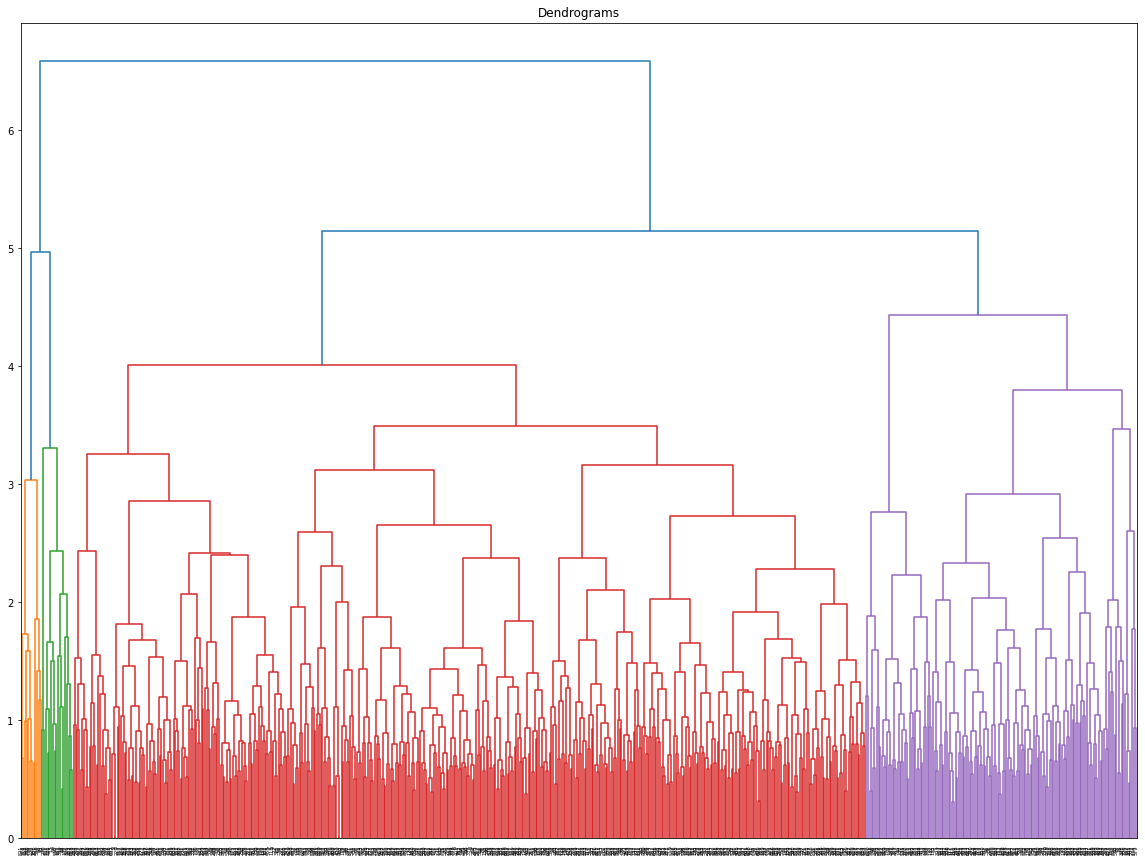

In [240]:
plt.figure(figsize=(20, 15))  
plt.title("Dendrograms")  
model = AgglomerativeClustering(n_clusters=10, linkage='complete').fit(similarity_matrix)
print(model.labels_)
dend = shc.dendrogram(shc.linkage(similarity_matrix, method='complete'))

In [162]:
count = 0
for row in similarity_matrix2:
    if 0 not in row:
        count += 1
print(count)

333


In [160]:
similarity_matrix.shape

(638, 638)

In [ ]:
# !pip install spacy

In [3]:
# !python -m spacy download en_core_web_md

In [4]:
# !python -m spacy link en_core_web_md en

In [146]:
import spacy
nlp = spacy.load('en_core_web_md')

In [149]:
def spacy_semantic_similarity(sentence1, sentence2):
    sentence1 = nlp(sentence1)
    sentence2 = nlp(sentence2)
    
    return sentence1.similarity(sentence2)

In [150]:
spacy_semantic_similarity('dog', 'cat')

0.8016854705531046

In [151]:
spacy_semantic_similarity('pen', 'pencil')

0.7085842403739737

In [152]:
spacy_semantic_similarity('dog-pen', 'cat-pencil')

0.8442632419880388

In [153]:
spacy_semantic_similarity('dog-pen', 'pencil-cat')

0.8442632438866646

In [234]:
similarity_matrix

array([[1.        , 0.8636068 , 0.62884218, ..., 0.68453741, 0.84662399,
        0.64814572],
       [0.8636068 , 1.        , 0.60285631, ..., 0.71408574, 0.86481099,
        0.68310445],
       [0.62884218, 0.60285631, 1.        , ..., 0.66912191, 0.71993989,
        0.76247785],
       ...,
       [0.68453741, 0.71408574, 0.66912191, ..., 1.        , 0.83309422,
        0.83355889],
       [0.84662399, 0.86481099, 0.71993989, ..., 0.83309422, 1.        ,
        0.83549071],
       [0.64814572, 0.68310445, 0.76247785, ..., 0.83355889, 0.83549071,
        1.        ]])

In [235]:
# import pickle

# with open('similarity_matrix', 'wb') as fp:
#     pickle.dump(similarity_matrix, fp)



In [236]:
# with open ('similarity_matrix', 'rb') as fp:
#     itemlist = pickle.load(fp)
# itemlist

array([[1.        , 0.8636068 , 0.62884218, ..., 0.68453741, 0.84662399,
        0.64814572],
       [0.8636068 , 1.        , 0.60285631, ..., 0.71408574, 0.86481099,
        0.68310445],
       [0.62884218, 0.60285631, 1.        , ..., 0.66912191, 0.71993989,
        0.76247785],
       ...,
       [0.68453741, 0.71408574, 0.66912191, ..., 1.        , 0.83309422,
        0.83355889],
       [0.84662399, 0.86481099, 0.71993989, ..., 0.83309422, 1.        ,
        0.83549071],
       [0.64814572, 0.68310445, 0.76247785, ..., 0.83355889, 0.83549071,
        1.        ]])

In [213]:
dataset['Fields'].iloc[:5,].tolist()

['Zinc-Cadmium-Soil pollution-Organoclay-Calcareous Soil-Bioavailability-Sulfur-oxidizing bacteria-Manures-Soil solutions-Salinity',
 'Yield-Medicinal Plant-Essential oils-Replacement corm-Germination-Azotobacter chroococcum-Crocus sativus-Phytotoxicity-Pseudomonas putida-Calcareous Soil',
 'Wireless sensor networks-Quality of service-Sensor nodes-Sensor networks-Network lifetime-Congestion control-Smart Grid-Internet protocols-Routing protocols-Clustering',
 'Wireless sensor networks-Quality of service-Congestion control-Sensor nodes-Network lifetime-Sensor networks-Smart Grid-Routing protocols-Internet protocols-Clustering',
 'Wireless sensor networks-Routing protocols-Quality of service-Sensor nodes-Smart Grid-Directional sensor network-Fairness-Coverage-Wireless multimedia sensor network-Optimization problems']

In [215]:
spacy_semantic_similarity('Wireless sensor networks-Quality of service-Sensor nodes-Sensor networks-Network lifetime-Congestion control-Smart Grid-Internet protocols-Routing protocols-Clustering', 'Wireless sensor networks-Routing protocols-Quality of service-Sensor nodes-Smart Grid-Directional sensor network-Fairness-Coverage-Wireless multimedia sensor network-Optimization problems'  )

0.9808482878758215